In [1]:
import pandas as pd

from create_csv import get_all_data

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Pull formatted data from the database
final_data, clicks = get_all_data()

DEFAULT_HIT_THRESHOLD = 5000
hit_miss_columns = [
        'beach-alert0-hit',
        'beach-alert1-hit',
        'beach-alert2-hit',
        'airport-alert0-hit',
        'airport-alert1-hit',
        'airport-alert2-hit',
        'city-alert0-hit',
        'city-alert1-hit',
        'city-alert1-hit',
    ]
phases = ['city', 'beach', 'airport']

def add_hit_miss_columns(data):
    for phase in phases:
        for alert in range(3):
            data[phase + '-alert' + str(alert) + '-hit'] = 0

def get_hit_miss(data, clicks, hit_threshold_ms):
    add_hit_miss_columns(data)
    for index, subject in data.iterrows():
        for phase in phases:
            subject_clicks_this_phase = clicks[subject['groupID']][phase].tolist()
            phase_start = subject[phase + '-start-time']
            for alert in subject[phase + '-alert-order']:
                alert_time = subject[phase + '-alert' + str(alert) + '-time']
                for click in subject_clicks_this_phase:
                    # Idiot check
                    if click < phase_start:
                        print("Ruh roh, how did the clicks happen before the phase started?")
                    if alert_time < click < (alert_time + hit_threshold_ms):
                        data.loc[index, phase + '-alert' + str(alert) + '-hit'] = 1
                        # data[index][phase + '-alert' + str(alert) + '-hit'] = 1
                        break


get_hit_miss(final_data, clicks, DEFAULT_HIT_THRESHOLD)

print("done")


Error retrieving city-end-time from: 
Object:644057ba4a65a55c7447191b GroupID:A-8558
Error retrieving beach-end-time from: 
Object:644060395db95bbee031bb07 GroupID:B-5983
Error retrieving city-end-time from: 
Object:64406d6a9d88dcc1a74ed547 GroupID:C-366
Error retrieving beach-end-time from: 
Object:6440722c5b80d645c4596202 GroupID:D-3762
Error retrieving city-end-time from: 
Object:64407bcf0a830617c2d6525b GroupID:A-1676
Error retrieving beach-end-time from: 
Object:6442fbfa0139e7f9b5c8c8c5 GroupID:B-2695
Error retrieving city-end-time from: 
Object:6443025f435e57ed9db41922 GroupID:C-7434
Error retrieving beach-end-time from: 
Object:64430932368b5b5fb57a59d7 GroupID:D-9820
Error retrieving beach-end-time from: 
Object:6443143d7166151e87a9d726 GroupID:A-3801
Error retrieving city-end-time from: 
Object:64431a1058018c7549a04eda GroupID:B-4077
Error retrieving beach-end-time from: 
Object:64431e641ac6346e6c038a36 GroupID:C-2484
Error retrieving city-end-time from: 
Object:6446f0d463c0be0

In [2]:
def get_alert_average(data, alert):
    city = data['city-alert' + str(alert) + '-hit'].mean()
    beach = data['beach-alert' + str(alert) + '-hit'].mean()
    airport = data['beach-alert' + str(alert) + '-hit'].mean()
    return (city + beach + airport) / 3

def get_phase_average(data, phase: ['city', 'beach', 'airport']):
    a1 = data[phase + '-alert0-hit'].mean()
    a2 = data[phase + '-alert1-hit'].mean()
    a3 = data[phase + '-alert2-hit'].mean()
    return (a1 + a2 + a3) / 3

def get_subject_hit_rate(data, subject_index):
    average = 0
    for alert in hit_miss_columns:
        average = average + data.loc[subject_index, alert]

    return average / len(hit_miss_columns)

def print_hit_rate_percentage(data):
    print(f"Hit threshold = {DEFAULT_HIT_THRESHOLD}(ms)")

    for alert in range(3):
        average = get_alert_average(data, alert)
        print(f"Alert {alert} hit rate = {round(average * 100, 2)}%")

    for phase in phases:
        average = get_phase_average(data, phase)
        print(f"{phase} hit rate = {round(average * 100, 2)}%")


print_hit_rate_percentage(final_data)

Hit threshold = 5000(ms)
Alert 0 hit rate = 84.72%
Alert 1 hit rate = 84.72%
Alert 2 hit rate = 73.61%
city hit rate = 62.5%
beach hit rate = 90.28%
airport hit rate = 55.56%


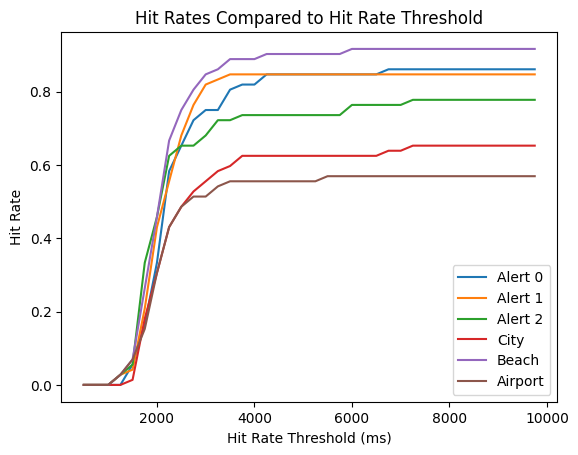

In [3]:
def plot_threshold_rate():
    hit_thresholds = np.arange(500, 10000, 250)

    hit_rates = pd.DataFrame(columns=['alert0', 'alert1', 'alert2', 'city', 'beach', 'airport'], index=hit_thresholds)
    for threshold_index in range(len(hit_thresholds)):
        get_hit_miss(final_data, clicks, hit_thresholds[threshold_index])
        for alert in range(3):
            hit_rates.loc[hit_thresholds[threshold_index], 'alert' + str(alert)] = get_alert_average(final_data, alert)

        for phase in phases:
            hit_rates.loc[hit_thresholds[threshold_index], phase] = get_phase_average(final_data, phase)

    plt.plot(hit_thresholds, hit_rates['alert0'], label='Alert 0')
    plt.plot(hit_thresholds, hit_rates['alert1'], label='Alert 1')
    plt.plot(hit_thresholds, hit_rates['alert2'], label='Alert 2')
    plt.plot(hit_thresholds, hit_rates['city'], label='City')
    plt.plot(hit_thresholds, hit_rates['beach'], label='Beach')
    plt.plot(hit_thresholds, hit_rates['airport'], label='Airport')

    plt.xlabel("Hit Rate Threshold (ms)")
    plt.ylabel("Hit Rate")
    plt.title("Hit Rates Compared to Hit Rate Threshold")

    plt.legend()

    plt.show()

plot_threshold_rate()

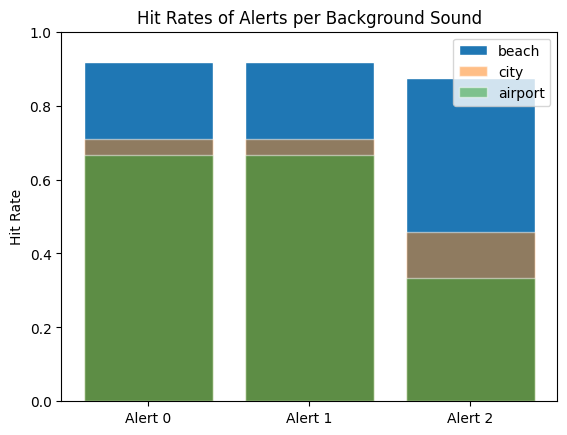

In [4]:
def plot_hit_rates_per_phase():
    fig, ax = plt.subplots()
    alerts = ['Alert 0', 'Alert 1', 'Alert 2']
    alphas = iter([1, .5, .5])

    for phase in ['beach', 'city', 'airport']:
        a0 = final_data[phase + '-alert0-hit'].mean()
        a1 = final_data[phase + '-alert1-hit'].mean()
        a2 = final_data[phase + '-alert2-hit'].mean()

        ax.bar(alerts, [a0, a1, a2], edgecolor="white", label=phase, alpha=next(alphas))

    ax.set(ylim=(0, 1))

    plt.legend()
    plt.ylabel("Hit Rate")
    plt.title("Hit Rates of Alerts per Background Sound")

    plt.show()

get_hit_miss(final_data, clicks, DEFAULT_HIT_THRESHOLD)
plot_hit_rates_per_phase()

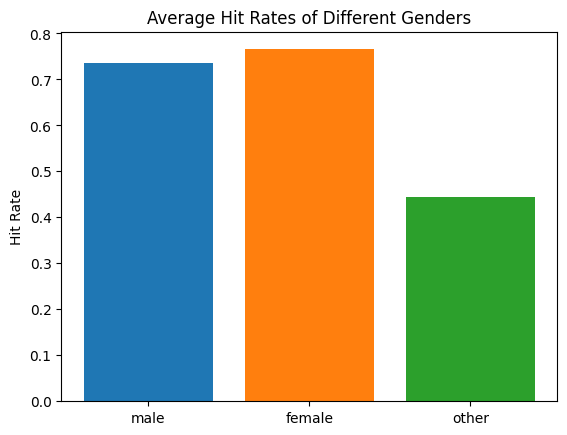

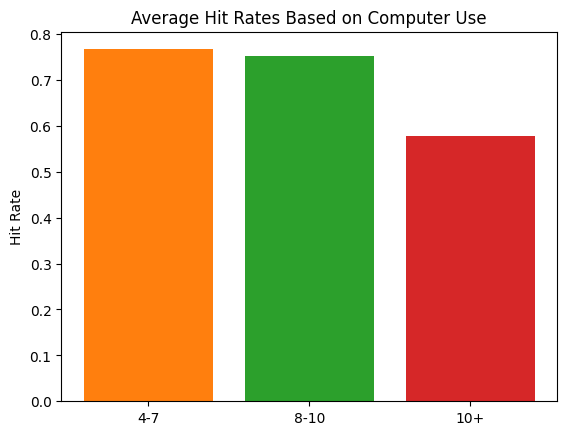

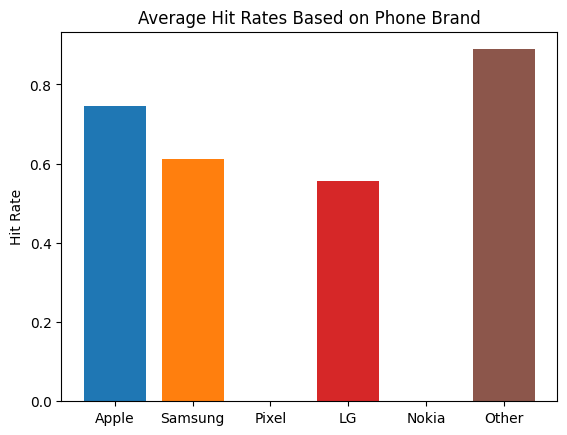

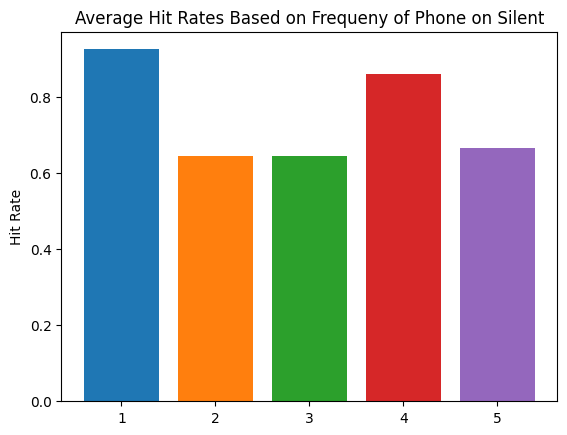

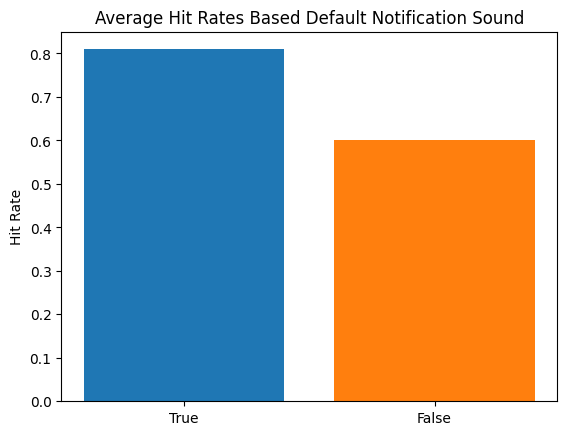

In [5]:
def demographics_bar_chart(data, key, potentials, title: str):
    fig, ax = plt.subplots()

    for subset in potentials:
        selected_subset = data.loc[final_data[key] == subset]
        average = 0
        for hit in hit_miss_columns:
            average = average + selected_subset[hit].mean()

        p = ax.bar(subset, average / len(hit_miss_columns), label="Label")
        # if p :ax.bar_label(p, label_type='center')

    # ax.bar(potentials, averages, label=f"{}")
    plt.title(title)
    plt.ylabel("Hit Rate")

    plt.show()

demographics_bar_chart(final_data, 'gender', ['male', 'female', 'other'], "Average Hit Rates of Different Genders")
demographics_bar_chart(final_data, 'computerUse', ['1-3', '4-7', '8-10', '10+'], "Average Hit Rates Based on Computer Use")
demographics_bar_chart(final_data, 'brand', ['Apple', 'Samsung', 'Pixel', 'LG', 'Nokia', 'Other'], "Average Hit Rates Based on Phone Brand")
demographics_bar_chart(final_data, 'silent', ['1', '2', '3', '4', '5'], "Average Hit Rates Based on Frequeny of Phone on Silent")
demographics_bar_chart(final_data, 'defaultNotification', ['True', 'False'], "Average Hit Rates Based Default Notification Sound")

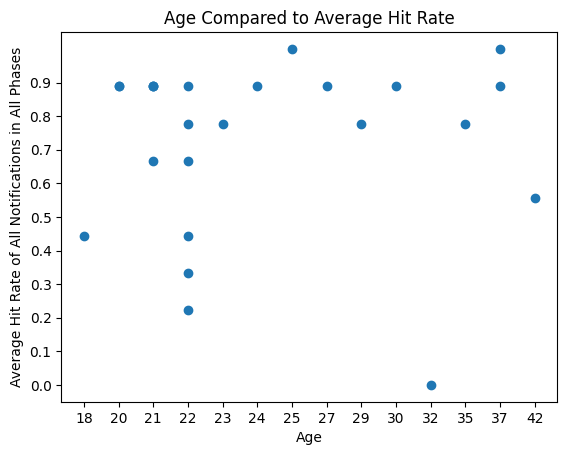

In [6]:
def plot_age_perfomrance_scatter():
    ages = np.arange(0,50,1)
    averages = []
    sorted_data = final_data.sort_values(by=['age'])

    for subject_index in range(len(sorted_data)):
        averages.append(get_subject_hit_rate(sorted_data, subject_index))

    fig, ax = plt.subplots()
    ax.scatter(sorted_data['age'], averages)
    plt.yticks(np.arange(0, 1, .1))
    ax.set_xlabel("Age")
    ax.set_ylabel("Average Hit Rate of All Notifications in All Phases")

    plt.title("Age Compared to Average Hit Rate")
    
    plt.show()

plot_age_perfomrance_scatter()

In [7]:
# Save data to csv

final_data.to_csv('../data/final-data.csv')